# Parkinson's Disease Progression Prediction

В этом нотбуке проведено исследование и обучение модели на данных AMP®-Parkinson's Disease Progression Prediction. 
Модель должна предсказывать баллы MDS-UPDR, которые измеряют прогрессирование у пациентов болезни Паркинсона.

#### Подключим библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import catboost as cb
from catboost import Pool, cv

# Настроим библиотеки отрисовки
%matplotlib inline

### Загрузим наши данные

## Basic view

In [2]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

# sample_submission = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv')
# test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
# test_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
# test_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')


Теперь мы подробно рассмотрим каждый из этих DataFrame (таблиц). 

UPDRS является инструментом оценки, используемым для измерения тяжести и прогрессирования болезни Паркинсона у пациентов. Когда пациент посещает клинику, клиника записывает, как пациент прошел тест UPDRS по 4 частям. Эти данные можно найти в train_clinical. Рейтинги для первых 4 сегментов UPDRS доступны в train_clinical как updrs_1, updrs_2, updrs_3 и updrs_4. Наша цель - обучить модель, чтобы она могла предсказывать эти рейтинги UPDRS.

Давайте рассмотрим датасет train_clinical.

In [3]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


In [4]:
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


Клиника также будет записывать значение NPX (нормализованная экспрессия белков), связанных с болезнью Паркинсона, для каждого посещения пациента. NPX представляет собой значение, представляющее концентрацию белка в оболочках. Эти данные доступны в DataFrame train_proteins.

Давайте рассмотрим датасет train_proteins.

In [5]:
print('clinical dataset shape:  ', train_proteins.shape)

clinical dataset shape:   (232741, 5)


Белки представляют собой длинные молекулы, состоящие из нескольких пептидов. Клиника будет регистрировать изобилие пептидов в белках, имеющих отношение к болезни Паркинсона, аналогичную NPX для белков. Эти данные можно находятся в датасете train_peptides.

Давайте рассмотрим датасет train_peptides.

In [6]:
print('clinical dataset shape:  ', train_peptides.shape)

clinical dataset shape:   (981834, 6)


In [7]:
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


### Plotting data

Мы выберем случайных пациентов и построим график значений целевой метки (updrs_1, updrs_2, updrs_3, updrs_4) данных пациентов на каждый месяц.

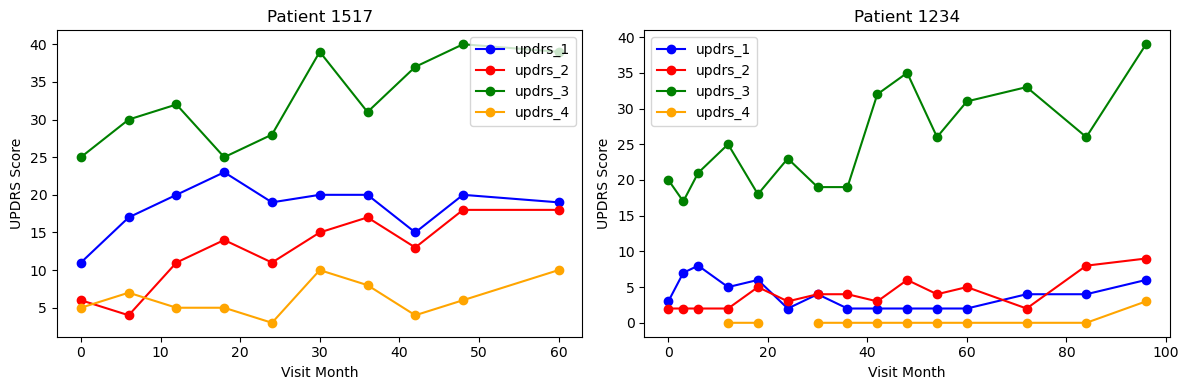

In [8]:
# График для первого пациента
plot_df1 = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(plot_df1['visit_month'], plot_df1['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax[0].plot(plot_df1['visit_month'], plot_df1['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax[0].plot(plot_df1['visit_month'], plot_df1['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax[0].plot(plot_df1['visit_month'], plot_df1['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")
ax[0].legend()
ax[0].set_xlabel('Visit Month')
ax[0].set_ylabel('UPDRS Score')
ax[0].set_title('Patient 1517')

# График для второго пациента
plot_df2 = train_clinical[train_clinical["patient_id"]==942]
ax[1].plot(plot_df2['visit_month'], plot_df2['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax[1].plot(plot_df2['visit_month'], plot_df2['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax[1].plot(plot_df2['visit_month'], plot_df2['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax[1].plot(plot_df2['visit_month'], plot_df2['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")
ax[1].legend()
ax[1].set_xlabel('Visit Month')
ax[1].set_ylabel('UPDRS Score')
ax[1].set_title('Patient 1234')

plt.tight_layout()
plt.show()

Отобразим первые 40 записей белка пациента и их значение NPX в зависимости от месяца посещения пациента.

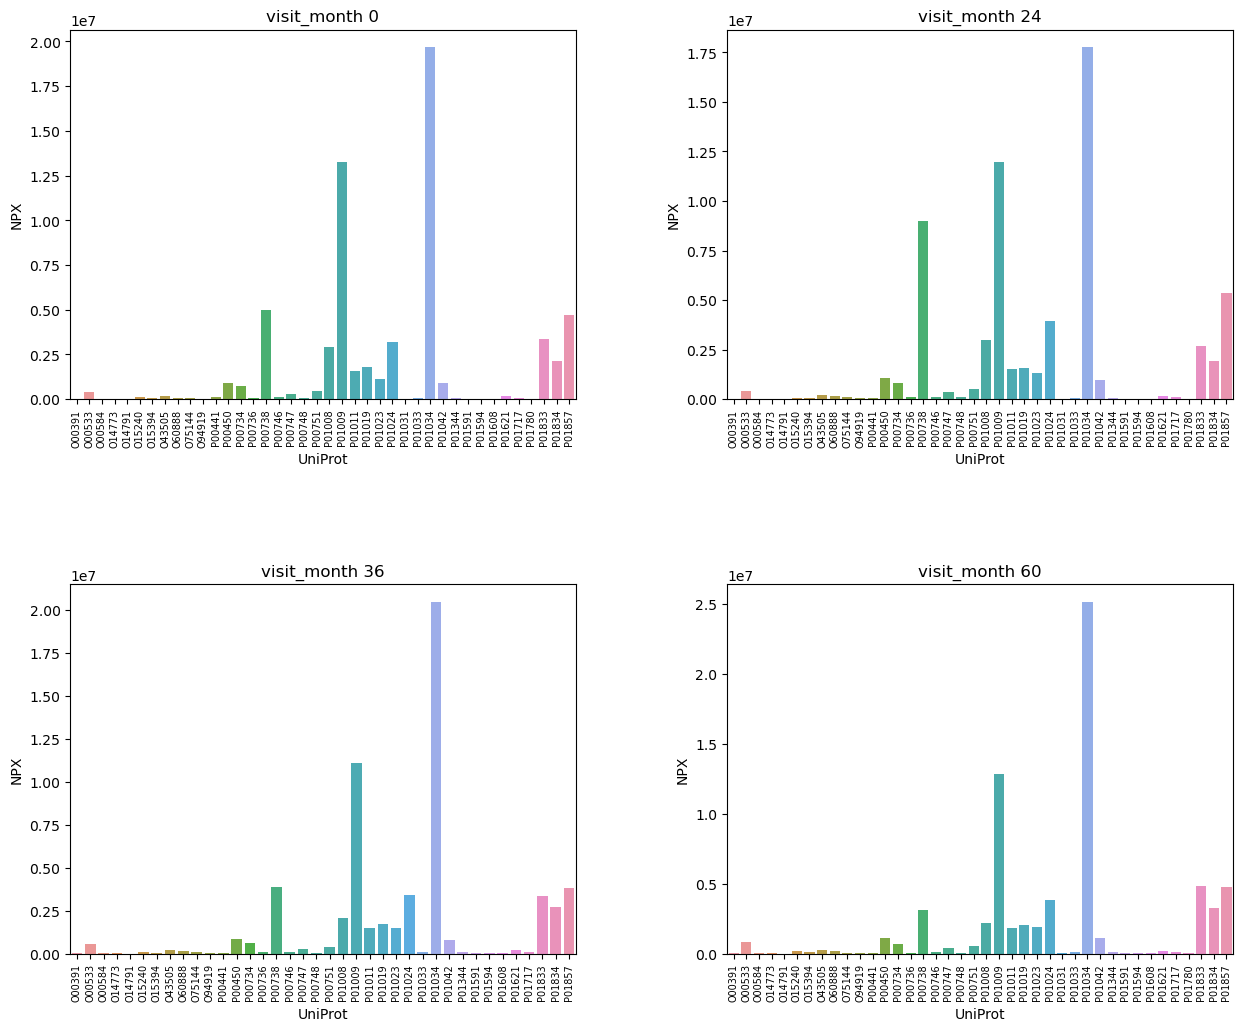

In [9]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = int(np.ceil(p_len/2))
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))

## Prepare the dataset

Чтобы предсказать целевые метки (updrs_1, updrs_2, updrs_3, updrs_4) для визита, мы будем использовать записанные данные о белках и пептидах пациента во время прошлых везитов.

Сначала мы сгруппируем строки данных train_proteins по идентификаторам посещений (visit id) и идентификаторам белков (UniProt). Затем мы заменим значения NPX каждой строки в группе средним значением значений NPX всех строк в этой группе.
Точно так же мы сгруппируем строки в данных train_peptides по их идентификаторам посещений (visit_id) и идентификаторам пептидов (Peptide). Затем мы заменим значения PeptideAbundance каждой строки в группе средним значением значений PeptideAbundance всех строк в этой группе.

In [10]:
df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

Набор данных Protein сводится таким образом, что уникальные значения visit_id становятся индексами, а значения UniProt1 в наборе данных становятся столбцами. Для каждого посещения значения NPX, соответствующие различным значениям UniProt1, записанным для этого посещения, фиксируются в столбцах. Данные о пептидах сводятся аналогично (значения Peptide в наборе данных становятся столбцами, значения PeptideAbundance записанны для своего посящения в столбцах)

In [11]:
df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()

Теперь мы объединим сводной набор данных о пептидах с сводным набором данных о белках на visit_id.

In [12]:
pp_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')

In [13]:
pp_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


Добавим в датасет месяца из train_clinical

In [14]:
single_df = pp_df.merge(train_clinical[['visit_id', 'visit_month']], on = ['visit_id'], how = 'left')

In [15]:
single_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80,12.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70,18.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98,12.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70,24.0
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN,12.0
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60,24.0
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,6310.09,NaN,28008.8,231359.0,63265.8,64601.8,632782.0,51123.7,20700.30,48.0


Напишем это код как функцию

In [16]:
def prepare_dataset(train_proteins, train_peptides):
    
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    pp_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pp_df

# Future Engineering 


In [17]:
FEATURES_1 = [i for i in single_df.columns if i not in ["visit_id"]]

In [18]:
# train_clinical['is_on_medication'] = train_clinical.apply(lambda row: 1 if row['upd23b_clinical_state_on_medication'] == 'On' else 0, axis=1)
# single_df = single_df.merge(train_clinical[['visit_id', 'is_on_medication']], how='left', left_on='visit_id', right_on='visit_id')
single_df['peptide_sum'] = single_df.iloc[:, 1:228].sum(axis=1)
single_df['protein_sum'] = single_df.iloc[:, 228:1196].sum(axis=1)
single_df['protein_to_peptide_ratio'] = single_df['protein_sum'] / single_df['peptide_sum']

In [19]:
single_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,peptide_sum,protein_sum,protein_to_peptide_ratio
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,583075.0,76705.7,104260.0,530223.0,NaN,7207.30,0.0,4.713356e+08,4.713352e+08,0.999999
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80,12.0,4.666370e+08,4.666371e+08,1.000000
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70,18.0,5.220732e+08,5.220732e+08,1.000000
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98,12.0,6.515605e+08,6.515605e+08,1.000000
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,496737.0,80919.3,111799.0,NaN,56977.6,4903.09,24.0,6.720872e+08,6.720870e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70,24.0,6.618367e+08,6.618368e+08,1.000000
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,250397.0,65966.9,77976.8,486239.0,45032.7,NaN,12.0,5.540191e+08,5.540194e+08,1.000001
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60,24.0,5.677028e+08,5.677032e+08,1.000001
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,231359.0,63265.8,64601.8,632782.0,51123.7,20700.30,48.0,5.979835e+08,5.979831e+08,0.999999


# Exploratory data analysis

### Первичный осмотр

Посмотрим на размер нашего датасета

In [20]:
single_df.shape

(1113, 1200)

Рассмотрим информацию о нашем датасете

In [21]:
single_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,peptide_sum,protein_sum,protein_to_peptide_ratio
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000,1068.000000,1.113000e+03,1.113000e+03,1.113000e+03
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823,26.744382,5.671262e+08,5.671262e+08,1.000000e+00
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380,22.839426,9.257932e+07,9.257932e+07,5.791003e-07
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300,0.000000,2.226464e+07,2.226459e+07,9.999981e-01
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000,6.000000,5.106672e+08,5.106668e+08,9.999996e-01
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000,24.000000,5.634755e+08,5.634750e+08,1.000000e+00
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000,48.000000,6.217859e+08,6.217864e+08,1.000000e+00
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000,108.000000,9.365054e+08,9.365051e+08,1.000002e+00


Пока можно сказать только о том, что все признаки числовые, и их очень много. Рассматривать каждый будет очень расточительно, поэтому сделаем общий осмотр датасета

Убедимся что в датасете нет дублей

In [22]:
single_df.duplicated().any()

False

### Поиск выбросов

Выбросы могут плохо повлиять на нашу модель или помешать в заполнении пропусков, поэтому мы займемся их поиском

Удалим нечисловую колонку

In [23]:
data_clean = single_df.drop('visit_id', axis=1)
visit_id = single_df.visit_id
data_drop = data_clean.copy()

Будем искать выбросы с помощью квантилей

In [24]:
for i in data_clean:
  # Рассчитаем первый и третий квантили поля Site EUI или возьмем значения из вывода метода describe
  first_quartile = data_clean[i].describe()['25%']
  third_quartile = data_clean[i].describe()['75%']

  # Рассчитаем IQR как разницу между третьим и первым квантилями
  iqr = third_quartile - first_quartile

  # Создадим условие на столбец Site EUI для отбора НЕ выбросов, воспользовавшись выражением выше
  condition = (data_clean[i] > (first_quartile - 3 * iqr)) & (data_clean[i] < (third_quartile + 3 * iqr))

  # Применим созданное условие к нашим данным, отфильтровав тем самым строки, не являющиеся выбросами
  data_drop = data_clean[condition]




Все выбросы успешно удалены, посмотрим теперь на размер нашего датасета

In [25]:
data_drop.shape

(1113, 1199)

### Заполнение пропусков

Перед тем ка заполнить пропуски нужно удалить значения, в которых большинство значений неизвестны

Так как наших столбцов много, мы рассмотрим колонки в порядке убывания количества пропусков

In [26]:
nan_sr = single_df.isna().sum()
max_nan = sorted(nan_sr, reverse=True)
print(max_nan[:20])

[624, 624, 550, 523, 514, 508, 507, 507, 497, 497, 494, 492, 482, 459, 459, 454, 452, 452, 451, 449]


Найдем название колонок с критическими значениями

In [27]:
for i,v in nan_sr.iteritems():
  if v >= 600:
    print(f"{i} : {v}")

Q99829 : 624
QALPQVR : 624


/tmp/ipykernel_20/3947779320.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,v in nan_sr.iteritems():


Удалим эти колонки

In [28]:
df_drop = data_drop.drop(['Q99829','QALPQVR'], axis=1)

Путем экспериментов решено было заполнить пропуски средним значением с шумом

Сделаем это

In [29]:
def fill_with_noise(value, noise_level):
  noise = np.random.normal(scale=noise_level)
  return value + noise
# Установка уровня шума
noise_level = 0.1
for col in df_drop.columns:
  is_missing = df_drop[col].isnull()
  num_missing = is_missing.sum()
  if num_missing > 0:
    mean = df_drop[col].mean()
    std = df_drop[col].std()
    fill_values = np.random.normal(loc=mean, scale=std, size=num_missing)
    df_drop.loc[is_missing, col] = [fill_with_noise(value, noise_level) for value in fill_values]

С пропусками мы закончили, теперь вернем нашу колонку "visit_id" и посмотрим на наш датасет

In [30]:
train_df = df_drop.join(visit_id, rsuffix='_visit_id')
train_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,peptide_sum,protein_sum,protein_to_peptide_ratio,visit_id
0,9104.27,402321.0,26615.649666,24745.614877,7150.570000,2497.840000,83002.9,15113.6,167327.0,129048.0,...,76705.7,104260.0,530223.000000,39653.507812,7207.30,0.0,4.713356e+08,4.713352e+08,0.999999,10053_0
1,10464.20,435586.0,30869.892769,47442.902819,23729.826687,4956.764501,197117.0,15099.1,164268.0,108114.0,...,92078.1,123254.0,453883.000000,49281.900000,25332.80,12.0,4.666370e+08,4.666371e+08,1.000000,10053_12
2,13235.70,507386.0,7126.960000,24525.700000,15452.276985,2372.710000,126506.0,16289.6,168107.0,163776.0,...,63203.6,128336.0,447505.000000,52389.100000,21235.70,18.0,5.220732e+08,5.220732e+08,1.000000,10053_18
3,12600.20,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,56725.0,...,89822.1,129964.0,552232.000000,65657.800000,9876.98,12.0,6.515605e+08,6.515605e+08,1.000000,10138_12
4,12003.20,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,85767.1,...,80919.3,111799.0,753896.230213,56977.600000,4903.09,24.0,6.720872e+08,6.720870e+08,1.000000,10138_24


# Training and submission

## CatBost

Теперь нам осталось обучить модель на наших данных и предсказать метки по тестовому набору

Что бы наша модель хорошо и быстро работала, мы применим PCA разложение, после чего отмасштабируем значения методом MinMaxScaler и начнем предсказывать значения с помощью модели CatBost

In [31]:
FEATURES = [i for i in train_df.columns if i not in ["visit_id"]]

In [32]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [33]:
def get_predictions(test_df, train_df):
    
    # Создадим необходимые переменные
    target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    temp = test_df[FEATURES].copy()
    new_test_df = test_df.copy()
    pred = test_df.copy()
    len_test = test_df.shape[0]
    
    # Используем цикл для последовательного предсказания каждой метки
    for label in target:
        
        print(label) # для отслеживания итерации
        
        dataset_df = train_df.merge(train_clinical[['visit_id', label]], on=['visit_id'], how='left') # добавляем таргет
        dataset_drop_label = dataset_df.dropna(subset=[label]) # удаляем пропуски в колонке таргета
        
        # Для удоства и сокращения кода мы объединим данные test и train, что бы вместе их форматировать
        combined_df = pd.concat([dataset_drop_label, test_df], ignore_index=True)
        combined_df = combined_df.drop('visit_id', axis=1)
        # Удалим таргетную колонку, что бы произвести PCA разложение, а также удалим visit_month
        # Так ка наше предсказание временное, зависимость от месяца очень важна, поэтому мы не будем
        # редактировать эту колонку
        combined_df_d = combined_df.drop(columns=[label, 'visit_month'])
        
        
        scaler_df = combined_df_d.copy()
        scaler = MinMaxScaler()
        scale = scaler.fit_transform(scaler_df)
        scale = pd.DataFrame(scale)
        # PCA разложение
        X_pca = scale.copy()
        pca = PCA(n_components=400)
        pca.fit(X_pca)
        Y_pca = pca.fit_transform(X_pca)
        Y_pca_df = pd.DataFrame(Y_pca)
        Y_pca_df['visit_month'] = combined_df['visit_month']
        
        # Maсштабирование
#         scaler = MinMaxScaler()
#         Y_pca_df.columns = Y_pca_df.columns.astype(str)
#         Y_pca_df = scaler.fit_transform(Y_pca_df)
#         Y_pca_df = pd.DataFrame(Y_pca_df)
        
        # Разделяем test и train
        train_Y_pca = Y_pca_df.iloc[:-1 * len_test]
        test_df_extracted = Y_pca_df.tail(len_test)
        
        # Разделяем train для обучения
        X = train_Y_pca
        y = dataset_drop_label[label]
        
        # Обучаем модель
        CB_model = cb.CatBoostRegressor(verbose=0)
        CB_model.fit(X, y)
        
        # Предсказываем и записываем значения таргета
        predictions = CB_model.predict(test_df_extracted)
        pred['result_' + str(label)] = predictions
        new_test_df['result_' + str(label)] = pred['result_' + str(label)]

    # Составляем submission фаил
    result = pd.DataFrame()
    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:
            temp = new_test_df[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp[['prediction_id', 'rating']]

            result = pd.concat([result, temp])
    result = result.drop_duplicates(subset=['prediction_id'])
    return result

In [34]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    
    #  Т.к. нам предстоит предсказание на 6,12,24 месяца вперед, создадим небольшой алгоритм,
    #  позволяющий нам записать эти месяца
    visit_list = [(i % 4) * 6 if i % 4 != 3 else 24 for i in range(len(test.visit_month))]
    test_month = test.copy()
    test_month.visit_month = visit_list
    
    # Соберем нашу тестовую выборку в 1 датасет
    pp_df = prepare_dataset(test_proteins, test_peptides)
    test_proteins = test_proteins.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
                  columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1).drop(columns=['visit_month', 'patient_id'])
    merged_df = test_month.merge(test_proteins, how='left', on='visit_id')
    test_df = test_month.merge(pp_df, how='left', on='visit_id')
    
    # Добавляет пропущеные колонки
    # Нам это нужно, что бы test и train совпадали
    for col in FEATURES_1:
        if col not in test_df.columns:
            test_df[col] = 0
    test_df = test_df[['visit_id'] + FEATURES_1]
    
    df = test_df.copy()
    #     test['is_on_medication'] = test.apply(lambda row: 1 if row['upd23b_clinical_state_on_medication'] == 'On' else 0, axis=1)
    #     test_df = test_df.merge(test[['visit_id', 'is_on_medication']], how='left', left_on='visit_id', right_on='visit_id')
    df['peptide_sum'] = test_df.iloc[:, 1:228].sum(axis=1)
    df['protein_sum'] = test_df.iloc[:, 228:1196].sum(axis=1)
    df['protein_to_peptide_ratio'] = df['protein_sum'] / df['peptide_sum']
    
    df = df[['visit_id','peptide_sum', 'protein_to_peptide_ratio','protein_sum']]
    test_df = test_df.merge(df, how='left', on='visit_id')
    
    # Заполним пропуски также как в train
    test_clean = test_df.drop('visit_id', axis=1)
    visit_id_test = test_df.visit_id
    
    def fill_with_noise(value, noise_level):
        noise = np.random.normal(scale=noise_level)
        return value + noise
    # Установка уровня шума
    noise_level = 0.1
    for col in test_clean.columns:
        is_missing = test_clean[col].isnull()
        num_missing = is_missing.sum()
        if num_missing > 0:
            mean = test_clean[col].mean()
            std = test_clean[col].std()
            fill_values = np.random.normal(loc=mean, scale=std, size=num_missing)
            test_clean.loc[is_missing, col] = [fill_with_noise(value, noise_level) for value in fill_values]
            
    
    test_df = test_clean
    test_df = test_df.join(visit_id_test, rsuffix='_visit_id')
    test_df = test_df.drop(['Q99829','QALPQVR'], axis=1)
    # Предсказываем значения и составляем фаил submission
    sample_prediction_df = get_predictions(test_df, train_df)
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
updrs_1
updrs_2
updrs_3
updrs_4
updrs_1
updrs_2
updrs_3
updrs_4


Посмотрим на наш выходной фаил

In [35]:
sample_prediction_df.head() 

,prediction_id,rating
0,3342_6_updrs_1_plus_0_months,3.945391
16,50423_6_updrs_1_plus_0_months,4.631356
0,3342_6_updrs_2_plus_0_months,3.133658
16,50423_6_updrs_2_plus_0_months,4.429210
0,3342_6_updrs_3_plus_0_months,12.119353


In [36]:
sample_prediction_df.to_csv('sample_prediction_df')

# Вывод

По итогам моих исследований и практического опыта в области анализа данных и машинного обучения, я смог углубить свои знания о моделях для регрессии. Изучение различных моделей помогло мне понять их особенности, преимущества и ограничения. Я получил ценный опыт в выборе и настройке моделей, чтобы достичь наилучших результатов и осознал важность правильного выбора оптимизаторов и настройки их гиперпараметров.

Опыт работы с EDA был очень полезным. Я научился обнаруживать особенности данных, выявлять закономерности и обрабатывать пропущенные значения или выбросы. Этот этап предварительного анализа данных помогает построить более надежные модели и сделать более обоснованные выводы. Так-же было очень интересно найти подход к многопризнаковым моделям.

Участие в денежном соревновании принесло мне ценный опыт и позволило ощутить настоящую конкуренцию. Я столкнулся с высоким уровнем соперников, что показало мне, насколько важно постоянно совершенствоваться и изучать новые методы и подходы. Также я ознакомился с нотбуками на платформе Kaggle и изучил множество других решений. Это позволило мне получить представление о различных подходах к анализу данных и применению моделей.

В целом, мой опыт показал мне, что в области анализа данных и машинного обучения знания безграничны, и я осознал, что у меня еще многое предстоит изучить. Однако, я ощутил прогресс и уверенность в своих способностях, и я готов продолжать свое обучение и развитие в этой захватывающей области.